In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
%matplotlib inline
import time
from scipy.optimize import minimize
import os

plt.rcParams['text.usetex'] = True
plt.rcParams['axes.labelsize'] = 17.
plt.rcParams['legend.fontsize']=18.
plt.rcParams['axes.titlesize']=18.
plt.rcParams['legend.frameon'] = 'False'
plt.rcParams['legend.fontsize']=10
plt.rcParams['xtick.labelsize']=13.
plt.rcParams['ytick.labelsize']=13.
plt.rcParams['legend.numpoints']=1

In [2]:
base="./Oct30_2017/AT48888/BW Slices 1p4 Micron per Pixel/Direction_2_Slice_00"
ext=".tiff"
n_files=185
im=[]
for i in range(1,n_files+1):
    if i<10:
        im+=[Image.open(base+'00'+str(i)+ext)]
    elif i<100:
        im+=[Image.open(base+'0'+str(i)+ext)]
    else:
        im+=[Image.open(base+str(i)+ext)]
    
    im[i-1]=np.array(im[i-1])
    im[i-1][im[i-1]==255]=1

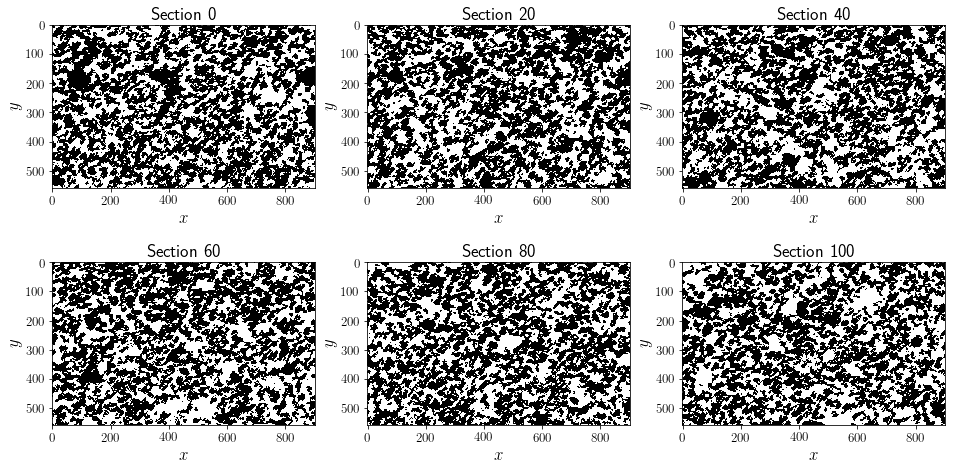

In [3]:
fig,ax=plt.subplots(2,3,figsize=(16,8))
some_files=[0,20,40,60,80,100]
for i, ax_i in enumerate(np.reshape(ax,6)):
    ax_i.imshow(im[some_files[i]],cmap=plt.get_cmap('binary'));
    ax_i.set_title('Section '+str(some_files[i]))
    ax_i.set_xlabel(r'$x$')
    ax_i.set_ylabel(r'$y$')

Black is 1. White is 0.

In [4]:
print('{0:.3f} of the medium is black.'.format(np.mean(im)))

0.552 of the medium is black.



# Naive estimation of S2 in real domain:

Complexity: $O((N_xN_y)^2)$

In [5]:
def get_S2(dx,dy,I,nx,ny):
    if (dx>=0)&(dy>=0):
        return np.sum(I[dx:,dy:]*I[:(nx-dx),:(ny-dy)])/(nx-dx)/(ny-dy)
    elif (dx>=0)&(dy<0):
        return np.sum(I[dx:,:(ny+dy)]*I[:(nx-dx),-dy:])/(nx-dx)/(ny+dy)
    elif (dx<0)&(dy>=0):
        return np.sum(I[:(nx+dx),dy:]*I[-dx:,:(ny-dy)])/(nx+dx)/(ny-dy)
    return np.sum(I[:(nx+dx),:(nx+dy)]*I[-dx:,-dy:])/(nx+dx)/(ny+dy)

In [6]:
Dx=1.4
nx=len(im[0])
ny=len(im[0][0])
max_xval=60
dx_max=int(np.ceil(max_xval/Dx))
S2_dx=np.arange(-dx_max,dx_max+1)
S2_dy=np.arange(0,dx_max+1)

In [7]:
t_S2=time.time()
S2=n_files*[np.zeros((2*dx_max+1,dx_max+1))]
for i_file in range(n_files):
    S2[i_file]=np.array([[get_S2(dx,dy,im[i_file],nx,ny) for dy in S2_dy] for dx in S2_dx])
t_S2=time.time()-t_S2
print('Time: {0:.2f} sec per section.'.format(t_S2/n_files))

Time: 1.76 sec per section.


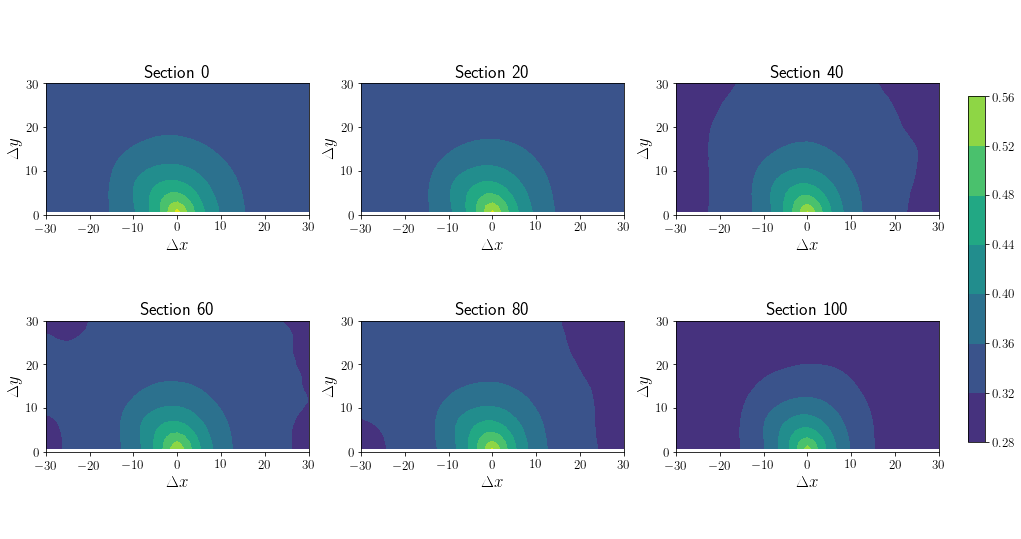

In [9]:
fig,ax=plt.subplots(2,3,figsize=(16,8))
for i, ax_i in enumerate(np.reshape(ax,6)):
    cntr_plot=ax_i.contourf(np.transpose(S2[some_files[i]]),origin='lower',extent=(-dx_max*Dx,dx_max*Dx,0,dx_max*Dx),vmin=.25,vmax=.6)
    ax_i.set_xlabel(r'$\Delta x$')
    ax_i.set_ylabel(r'$\Delta y$')
    ax_i.set_xlim(-30,30)
    ax_i.set_ylim(0,30)
    ax_i.set_title('Section '+str(some_files[i]))
    ax_i.set_aspect('equal')
ax_cbar=fig.add_axes([.84,.05,.1,.9],frame_on=False,xticks=[],yticks=[])
fig.add_axes()
cntr_bar=fig.colorbar(cntr_plot,ax=ax_cbar);

where $\Delta x:=\|\Delta \underline{x}\|$.
There seems to be a very light anisotropy.


# Naive estimation of S2 in frequency domain:

Complexity: $O(N_xN_ylog(N_xN_y))$. Memory: $O((N_xN_y)^2)$

In [10]:
t_S2=time.time()
S2_FFT=n_files*[None]
for i in range(n_files):
    hI=np.fft.rfft2(im[i])
    S2_FFT[i]=np.fft.irfft2(hI*np.conj(hI))/(nx*ny)
t_S2=time.time()-t_S2
print('Time: {0:.2f} sec per section.'.format(t_S2/n_files))

Time: 0.05 sec per section.


In [11]:
S2_FFT_mean=S2_FFT[0]/n_files
for j in range(1,n_files):
    S2_FFT_mean+=S2_FFT[j]/n_files
print('FFT average results (still anisotropic):')
print(S2_FFT_mean[0,:6])
print(S2_FFT_mean[:6,0])
print(np.array([S2_FFT_mean[k,k] for k in range(6)]))

FFT average results (still anisotropic):
[ 0.55246919  0.51910668  0.48963274  0.46450343  0.44283946  0.42366124]
[ 0.55246919  0.51724173  0.48414444  0.4546271   0.4292622   0.40796284]
[ 0.55246919  0.50216394  0.45935695  0.42523779  0.39898416  0.37890906]


In [12]:
S2_mean=S2[0]/n_files
for j in range(1,n_files):
    S2_mean=S2_mean+S2[j]/n_files
print('Results from estimates in real domain (still anisotropic):')
print(S2_mean[dx_max,:6])
print(S2_mean[dx_max:dx_max+6,0])
print(np.array([S2_mean[dx_max+k,k] for k in range(6)]))

Results from estimates in real domain (still anisotropic):
[ 0.55246919  0.51933914  0.4900329   0.46501919  0.44342724  0.42428157]
[ 0.55246919  0.51760775  0.48475457  0.45537945  0.4300774   0.40878105]
[ 0.55246919  0.50271494  0.46020609  0.42620848  0.39995974  0.37981308]


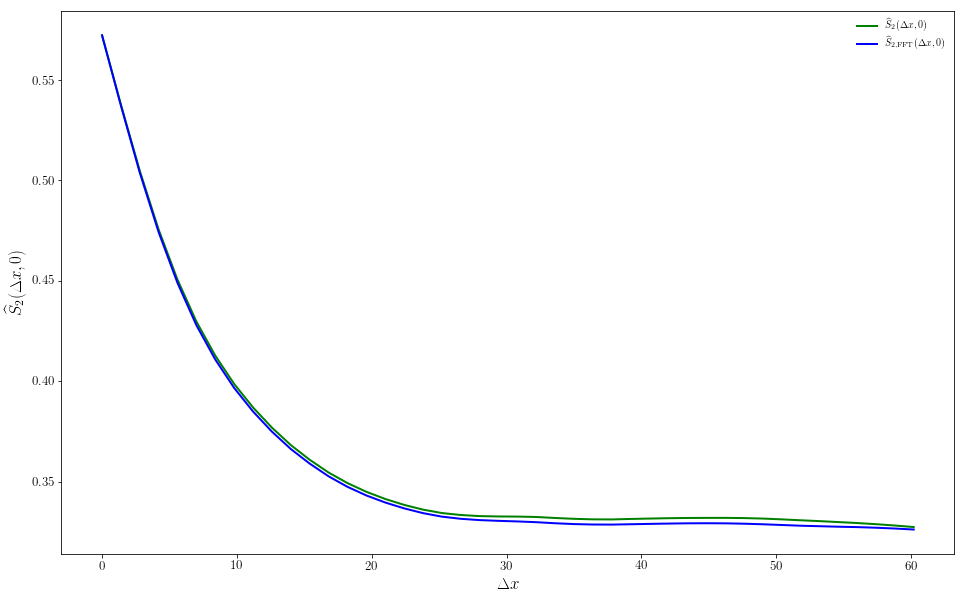

In [13]:
#fig,ax=plt.subplots(2,2,figsize=(16,10))
i=0
fig,ax=plt.subplots(1,1,figsize=(16,10))
ax.plot(S2_dy*Dx,S2[i][dx_max:,0],'g-',lw=2,label=r'$\widehat{S}_2(\Delta x,0)$')
ax.plot(S2_dy*Dx,S2_FFT[i][:dx_max+1,0],'b-',lw=2,label=r'$\widehat{S}_{2,\mathrm{FFT}}(\Delta x,0)$')
ax.legend()
ax.set_xlabel(r'$\Delta x$')
ax.set_ylabel(r'$\widehat{S}_2(\Delta x,0)$');


# Inference of isotropic exponential S2 model:

First, we consider the following isotropic model for $S_2(\Delta x)$,

\begin{align} 
S_2(\Delta x)=&\;\phi_1^2+\phi_1(1-\phi_1)\exp\left(-\frac{\Delta x}{a}\right)\\
S_2(\Delta x)=&\;\mathbb{E}[\mathcal{I}^{(1)}]^2+\mathbb{V}[\mathcal{I}^{(1)}]\exp\left(-\frac{\Delta x}{a}\right)\\
\end{align}

so that $S_2(0)=\mathbb{E}[\mathcal{I}^{(1)}\mathcal{I}^{(1)}]$.

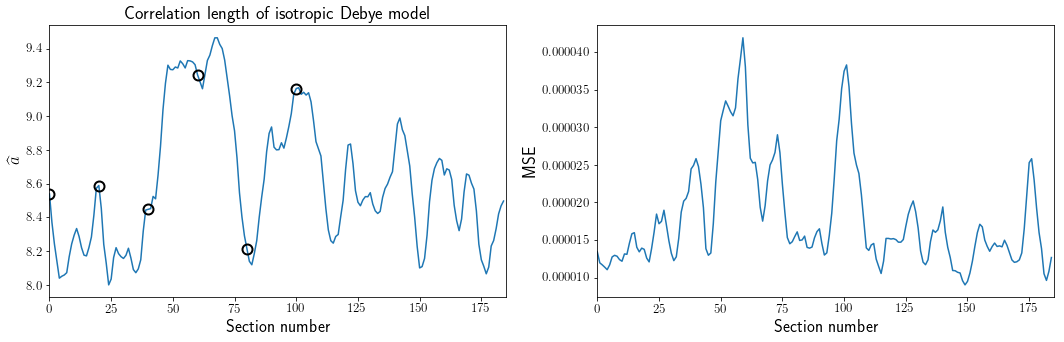

In [71]:
dx_vals=Dx*np.array([np.sqrt(S2_dy**2+dx**2) for dx in S2_dx])

a_LSQ=np.zeros(n_files)
res_LSQ=np.zeros(n_files)
for i in range(n_files):
    phi1=np.mean(im[i])
    res_S2_model=lambda a: np.sum((phi1**2+phi1*(1.-phi1)*np.exp(-dx_vals/a)-S2[i])**2)**.5
    res=minimize(res_S2_model,1.,method='Nelder-Mead',tol=1e-6)
    a_LSQ[i]=res.x
    res_LSQ[i]=res.fun**2/np.size(dx_vals)
    
fig,ax=plt.subplots(1,2,figsize=(18,5))
ax[0].plot(a_LSQ)
ax[0].set_ylabel(r'$\widehat{a}$')
ax[0].set_xlabel('Section number')
ax[0].set_title('Correlation length of isotropic Debye model');
ax[0].set_xlim(0,n_files)
ax[1].plot(res_LSQ)
ax[1].set_ylabel('MSE')
ax[1].set_xlabel('Section number')
ax[1].set_xlim(0,n_files)
for i in some_files:
    ax[0].plot(i,a_LSQ[i],'o',markerfacecolor='none',markeredgecolor='k',markeredgewidth=2,markersize=10,lw=0)

Assuming  $\; I^{(1)}(x,y,z)\; $ is stationary in the $xy$ plane, then it does not seem to be stationary along $\; z$.

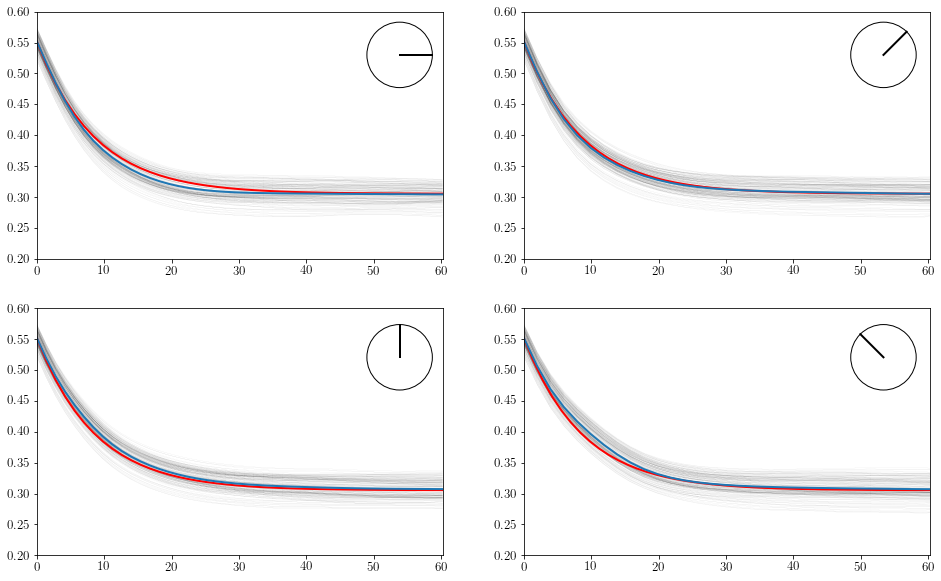

In [14]:
S2_mean=4*[np.zeros(dx_max+1)]
fig,ax=plt.subplots(2,2,figsize=(16,10))
for i in range(n_files):
    ax[0,0].plot(S2_dy*Dx,S2[i][dx_max:,0],'k-',lw=.02)
    S2_mean[0]=S2_mean[0]+S2[i][dx_max:,0]
    ax[0,1].plot(S2_dy*Dx*2**.5,[S2[i][dx_max+j,j] for j in range(dx_max+1)],'k-',lw=.02)
    S2_mean[1]=S2_mean[1]+np.array([S2[i][dx_max+j,j] for j in range(dx_max+1)])
    ax[1,0].plot(S2_dy*Dx,S2[i][dx_max,:],'k-',lw=.02)
    S2_mean[2]=S2_mean[2]+S2[i][dx_max,:]
    ax[1,1].plot(S2_dy*Dx*2**.5,[S2[i][j,dx_max-j] for j in range(dx_max,-1,-1)],'k-',lw=.02)
    S2_mean[3]=S2_mean[3]+np.array([S2[i][j,dx_max-j] for j in range(dx_max,-1,-1)])

ax2_extents=((.39,.77,.1,.1),(.81,.77,.1,.1),(.39,.35,.1,.1),(.81,.35,.1,.1))
circle_xy=np.array([.5,.5])
circle_r=.5
dx_circle=np.array([1,2**-.5,0,-2**-.5])*.5
dy_circle=np.array([0,2**-.5,1,2**-.5])*.5

phi1=np.mean(im)
S2_model=lambda dx: phi1**2+phi1*(1.-phi1)*np.exp(-dx/np.mean(a_LSQ))
fac=(1,2**.5,1,2**.5)
for i, ax_i in enumerate(np.reshape(ax,np.size(ax))):
    ax_i.plot(S2_dy*Dx,S2_model(S2_dy*Dx),'r-',lw=2)
    ax_i.plot(S2_dy*Dx*fac[i],S2_mean[i]/n_files,'-',lw=2)
    ax2=fig.add_axes(ax2_extents[i])
    ax2.add_artist(Ellipse(xy=circle_xy,width=2.*circle_r,height=2.*circle_r,angle=0.,facecolor='none',edgecolor='k',lw=1.))
    ax2.set_aspect('equal')
    ax2.set_xticks([]);ax2.set_yticks([])
    ax2.set_frame_on(False)
    ax2.plot([.5,.5+dx_circle[i]],[.5,.5+dy_circle[i]],'k-',lw=2)
    ax2.set_xlim(-.05,1.05);ax2.set_ylim(-.05,1.05)
    ax_i.set_xlim(0,dx_max*Dx)
    ax_i.set_ylim(.2,.6)  


# Inference of anisotropic exponential S2 model:

Let's consider the following anisotropic model for $S_2(\Delta \underline{x})$,

\begin{align} 
S_2(\Delta \underline{x})=&\;\phi_1^2+\phi_1(1-\phi_1)\exp\left(-[\Delta \underline{x}\cdot\mathbf{Z}\cdot\Delta \underline{x}]^{1/2}\right)\\
S_2(\Delta \underline{x})=&\;\mathbb{E}[\mathcal{I}^{(1)}]^2+\mathbb{V}[\mathcal{I}^{(1)}]\exp\left(-[\Delta \underline{x}\cdot\mathbf{Z}\cdot\Delta \underline{x}]^{1/2}\right)\\
\end{align}

where 
\begin{align}
\mathbf{Z}=
\frac{\underline{u}_1\otimes\underline{u}_1}{a_1^2}+
\frac{\underline{u}_2\otimes\underline{u}_2}{a_2^2}
\end{align}

with $\;\underline{u}_1=\cos(\theta)\underline{e}_1+\sin(\theta)\underline{e}_2\;$ and $\;\underline{u}_2=-\sin(\theta)\underline{e}_1+\cos(\theta)\underline{e}_2\;$, $\;\theta\in[0,\pi)\;$ and $\;a_1,a_2>0$.
Then, we have $S_2(\underline{0})=\mathbb{E}[\mathcal{I}^{(1)}\mathcal{I}^{(1)}]$.

In [73]:
dx_vals=np.array([np.sqrt(S2_dy**2+dx**2) for dx in S2_dx])

def Zmat(theta,a1,a2):
    u1=np.array([np.cos(theta),np.sin(theta)])
    u2=np.array([-np.sin(theta),np.cos(theta)])
    return np.outer(u1,u1)/a1**2+np.outer(u2,u2)/a2**2

def S2_model_ani(phi1,dx,th,a1,a2):
    return phi1**2+phi1*(1.-phi1)*np.exp(-(np.inner(dx,np.inner(Zmat(th,a1,a2),dx)))**.5)

p_LSQ=n_files*[None]
res_LSQ2=np.zeros(n_files)
for i in range(n_files):
    phi1=np.mean(im[i])
    res_S2_model=lambda p: np.sum((np.array([[S2_model_ani(phi1,np.array([dx,dy]),p[0],p[1],p[2]) for dy in S2_dy] for dx in S2_dx])-S2[i])**2)**.5
    res=minimize(res_S2_model,[np.pi/4.,10.,10.],method='Nelder-Mead',tol=1e-6)
    p_LSQ[i]=res.x
    if p_LSQ[i][0]>.7*np.pi/2.:
        p_LSQ[i][0]-=np.pi/2.
        p_LSQ[i][1],p_LSQ[i][2]=p_LSQ[i][2],p_LSQ[i][1]
    res_LSQ2[i]=res.fun**2/np.size(dx_vals)

In [ ]:
fig,ax=plt.subplots(2,2,figsize=(18,10))
ax[0,0].plot([p_LSQ[i][1] for i in range(n_files)])
ax[0,1].plot([p_LSQ[i][2] for i in range(n_files)])
ax[1,0].plot([p_LSQ[i][0] for i in range(n_files)])
ax[1,1].plot(res_LSQ2,label='Aniso.')
ax[1,1].plot(res_LSQ,label='Iso.')
ax[1,1].legend()
ax[0,0].set_ylabel(r'$\widehat{a}_1$')
ax[0,1].set_ylabel(r'$\widehat{a}_2$')
ax[1,0].set_ylabel(r'$\widehat{\theta}$')
ax[1,1].set_ylabel('MSE')
for i, ax_i in enumerate(np.reshape(ax,np.size(ax))):
    ax_i.set_xlabel('Section number')
    ax_i.set_xlim(0,n_files)

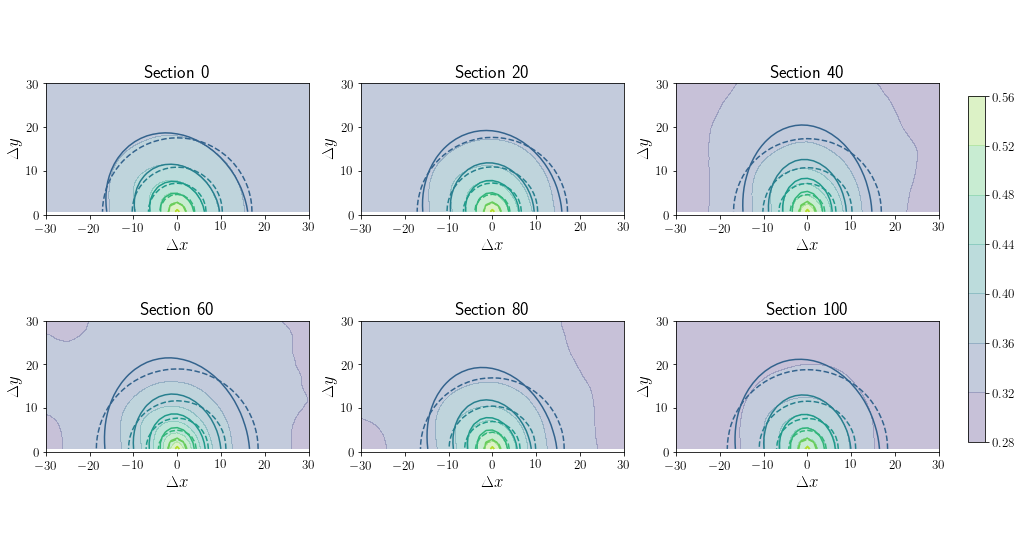

In [16]:
fig,ax=plt.subplots(2,3,figsize=(16,8))
for i, ax_i in enumerate(np.reshape(ax,np.size(ax))):
    j=some_files[i]
    phi1=np.mean(im[0])
    S2_iso=[[S2_model_ani(phi1,np.array([dx,dy])*Dx,0,a_LSQ[j],a_LSQ[j]) for dy in S2_dy] for dx in S2_dx]    
    S2_ani=[[S2_model_ani(phi1,np.array([dx,dy]),p_LSQ[j][0],p_LSQ[j][1],p_LSQ[j][2]) for dy in S2_dy] for dx in S2_dx]    
    cntr_plot=ax_i.contourf(np.transpose(S2[j]),origin='lower',alpha=.3,extent=(-dx_max*Dx,dx_max*Dx,0,dx_max*Dx),vmin=.25,vmax=.6)
    ax_i.contour(np.transpose(S2_ani),origin='lower',extent=(-dx_max*Dx,dx_max*Dx,0,dx_max*Dx),vmin=.25,vmax=.6)
    ax_i.contour(np.transpose(S2_iso),origin='lower',extent=(-dx_max*Dx,dx_max*Dx,0,dx_max*Dx),vmin=.25,vmax=.6,linestyles='dashed')
        
    ax_i.set_xlabel(r'$\Delta x$')
    ax_i.set_ylabel(r'$\Delta y$')
    ax_i.set_xlim(-30,30)
    ax_i.set_ylim(0,30)
    ax_i.set_title('Section '+str(j))
    ax_i.set_aspect('equal')

ax_cbar=fig.add_axes([.84,.05,.1,.9],frame_on=False,xticks=[],yticks=[])
fig.add_axes()
cntr_bar=fig.colorbar(cntr_plot,ax=ax_cbar);


#  Naive estimation of S3 in real domain:

Complexity: $O((N_xN_y)^3)$

In [14]:
def get_S3(dx1,dy1,dx2,dy2,I,nx,ny):
    x0_l=max(0,dx1,dx2)
    x0_r=min(nx,dx1+nx,dx2+nx)
    dx=x0_r-x0_l
    x1_l=x0_l-dx1
    x1_r=x1_l+dx
    x2_l=x0_l-dx2
    x2_r=x2_l+dx
    #
    y0_l=max(0,dy1,dy2)
    y0_r=min(ny,dy1+ny,dy2+ny)
    dy=y0_r-y0_l
    y1_l=y0_l-dy1
    y1_r=y1_l+dy
    y2_l=y0_l-dy2
    y2_r=y2_l+dy
    #
    return np.sum(I[x0_l:x0_r,y0_l:y0_r]*I[x1_l:x1_r,y1_l:y1_r]*I[x2_l:x2_r,y2_l:y2_r])/dx/dy

In [15]:
# S2-values are recoverable from S3:
print(get_S3(-9,3,0,0,im[0],nx,ny),get_S2(-9,3,im[0],nx,ny))
print(get_S3(-9,3,-9,3,im[0],nx,ny),get_S2(-9,3,im[0],nx,ny))

0.379772645145 0.379772645145
0.379772645145 0.379772645145


In [16]:
dx=1.4
nx=len(im[0])
ny=len(im[0][0])

In [147]:
max_xval=60
dx_max=int(np.ceil(max_xval/dx))

S3_dx=np.arange(0,dx_max+1)
S3_dy=np.arange(0,dx_max+1)

t_S3=time.time()
S3=[]

dirs=[( 1, 0, 0, 1),
      ( 1, 1,-1, 1),
      ( 0, 1,-1, 0),
      (-1, 1,-1,-1),
      (-1, 0, 0,-1),
      (-1,-1, 1,-1),
      ( 0,-1, 1, 0),
      ( 1,-1, 1, 1)]

for _dir in dirs:
    S3+=[np.array([[get_S3(_dir[0]*dx,_dir[1]*dx,_dir[2]*dy,_dir[3]*dy,im[0],nx,ny) for dy in S3_dy] for dx in S3_dx])]

t_S3=time.time()-t_S3
print('Time: {0:.2f} sec per map*section'.format(t_S3/4))

Time: 2.00 sec per map*section


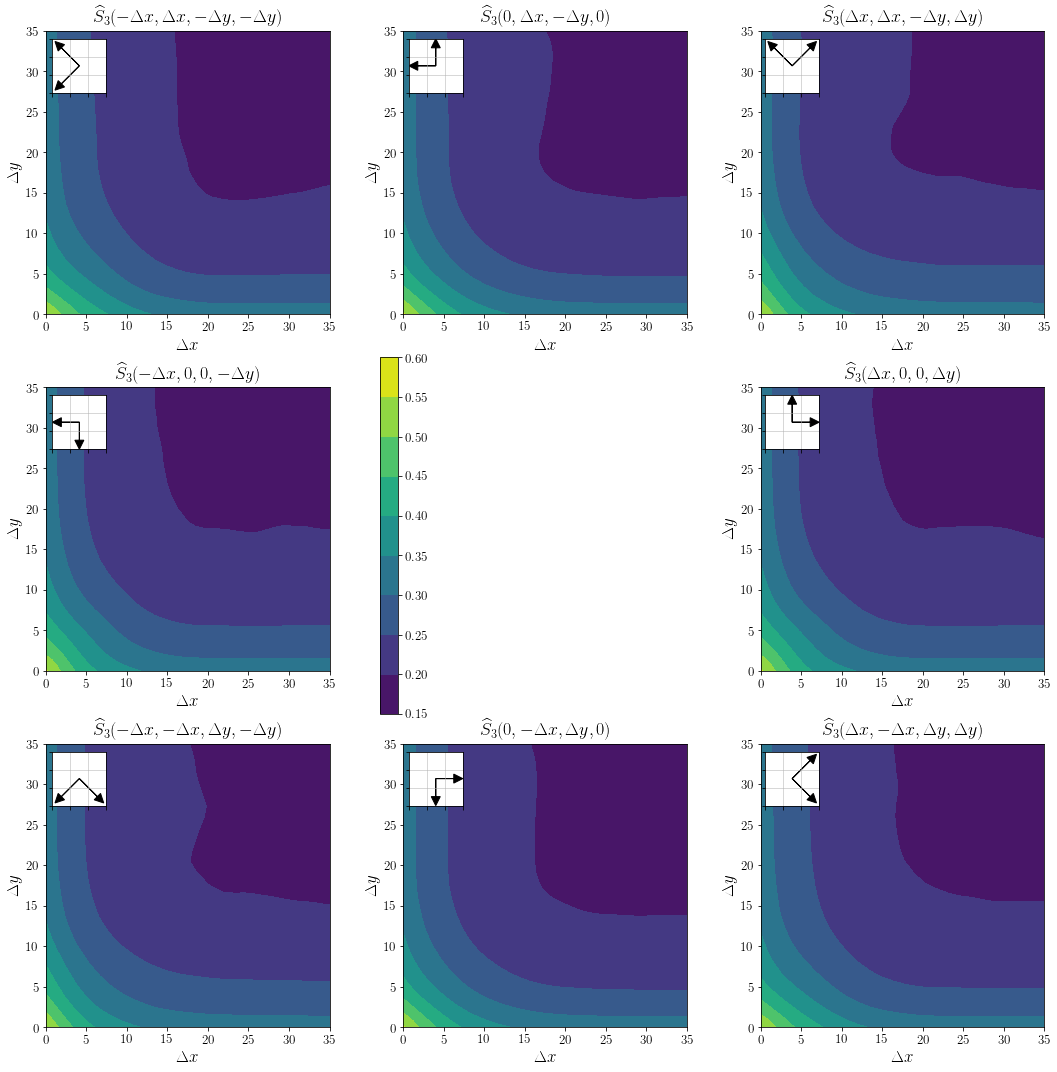

In [148]:
fig,ax=plt.subplots(3,3,figsize=(15,15))
pos=[(1,2), (0,2), (0,1), (0,0), (1,0), (2,0), (2,1), (2,2)]
ax[1,1].set_frame_on(False)
ax[1,1].set_xticks([]);ax[1,1].set_yticks([])
for i in range(len(S3)):
    d_scale_x=(dirs[i][0]**2+dirs[i][1]**2)**.5
    d_scale_y=(dirs[i][2]**2+dirs[i][3]**2)**.5
    cntr_plot=ax[pos[i][0],pos[i][1]].contourf(np.transpose(S3[i]),origin='lower',extent=(-dx/2.*d_scale_x,(dx_max-dx/2.)*d_scale_x,-dx/2.*d_scale_y,(dx_max-dx/2.)*d_scale_y),vmin=.15,vmax=.6)
    
ng=1
size_insert=.05
ax2_extents=((.72,.58,size_insert,size_insert),
             (.72,.91,size_insert,size_insert),
             (.39,.91,size_insert,size_insert),
             (.06,.91,size_insert,size_insert),
             (.06,.58,size_insert,size_insert),
             (.06,.25,size_insert,size_insert),
             (.39,.25,size_insert,size_insert),
             (.72,.25,size_insert,size_insert))

titles=(r'$\widehat{S}_3( \Delta x, 0       ,        0, \Delta y)$',
        r'$\widehat{S}_3( \Delta x, \Delta x,-\Delta y, \Delta y)$',
        r'$\widehat{S}_3(        0, \Delta x,-\Delta y,        0)$',
        r'$\widehat{S}_3(-\Delta x, \Delta x,-\Delta y,-\Delta y)$',
        r'$\widehat{S}_3(-\Delta x,        0,        0,-\Delta y)$',
        r'$\widehat{S}_3(-\Delta x,-\Delta x, \Delta y,-\Delta y)$',
        r'$\widehat{S}_3(        0,-\Delta x, \Delta y,        0)$',
        r'$\widehat{S}_3( \Delta x,-\Delta x, \Delta y, \Delta y)$')

for i in range(len(S3)):
    ax_i=ax[pos[i][0],pos[i][1]]
    ax_i.set_xlabel(r'$\Delta x$')
    ax_i.set_ylabel(r'$\Delta y$')
    ax_i.set_xlim(0,35)
    ax_i.set_ylim(0,35)
    ax_i.set_aspect('equal')
    ax_i.set_title(titles[i]) 
plt.tight_layout();
    
for i in range(len(S3)):
    ax2=fig.add_axes(ax2_extents[i])
    ax2.set_aspect('equal')
    ax2.set_xticks(range(-ng,ng+2),);ax2.set_yticks(range(-ng,ng+2))
    ax2.arrow(.5,.5,dirs[i][0],dirs[i][1], head_width=.5, head_length=.5, fc='k', ec='k')
    ax2.arrow(.5,.5,dirs[i][2],dirs[i][3], head_width=.5, head_length=.5, fc='k', ec='k')
    ax2.set_xlim(-ng,ng+1)
    ax2.set_ylim(-ng,ng+1)
    ax2.grid(linestyle='-',linewidth='0.5')
    for xlabel in ax2.get_xticklabels(): xlabel.set_visible(False)
    for ylabel in ax2.get_yticklabels(): ylabel.set_visible(False)     

ax_cbar=fig.add_axes([.27,.05,.11,.9],frame_on=False,xticks=[],yticks=[])
fig.add_axes()
cntr_bar=fig.colorbar(cntr_plot,ax=ax_cbar);


In [149]:
max_xval=60
dx_max=int(np.ceil(max_xval/dx))

S3_dx=np.arange(0,dx_max+1)
S3_dy=np.arange(0,dx_max+1)

t_S3=time.time()
S3=[]

dirs=[( 1, 0, 1, 1),
      ( 1, 1, 0, 1),
      ( 0, 1,-1, 1),
      (-1, 1,-1, 0),
      (-1, 0,-1,-1),
      (-1,-1, 0,-1),
      ( 0,-1, 1,-1),
      ( 1,-1, 1, 0)]

for _dir in dirs:
    S3+=[np.array([[get_S3(_dir[0]*dx,_dir[1]*dx,_dir[2]*dy,_dir[3]*dy,im[0],nx,ny) for dy in S3_dy] for dx in S3_dx])]

#S3+=[np.array([[get_S3(dx,0,dy,dy,im[0],nx,ny) for dy in S3_dy] for dx in S3_dx])]
#S3+=[np.array([[get_S3(dx,dx,0,dy,im[0],nx,ny) for dy in S3_dy] for dx in S3_dx])]
#S3+=[np.array([[get_S3(0,dx,-dy,dy,im[0],nx,ny) for dy in S3_dy] for dx in S3_dx])]
#S3+=[np.array([[get_S3(-dx,dx,0,dy,im[0],nx,ny) for dy in S3_dy] for dx in S3_dx])]
t_S3=time.time()-t_S3
print('Time: {0:.2f} sec per map*section'.format(t_S3/4))

Time: 2.07 sec per map*section


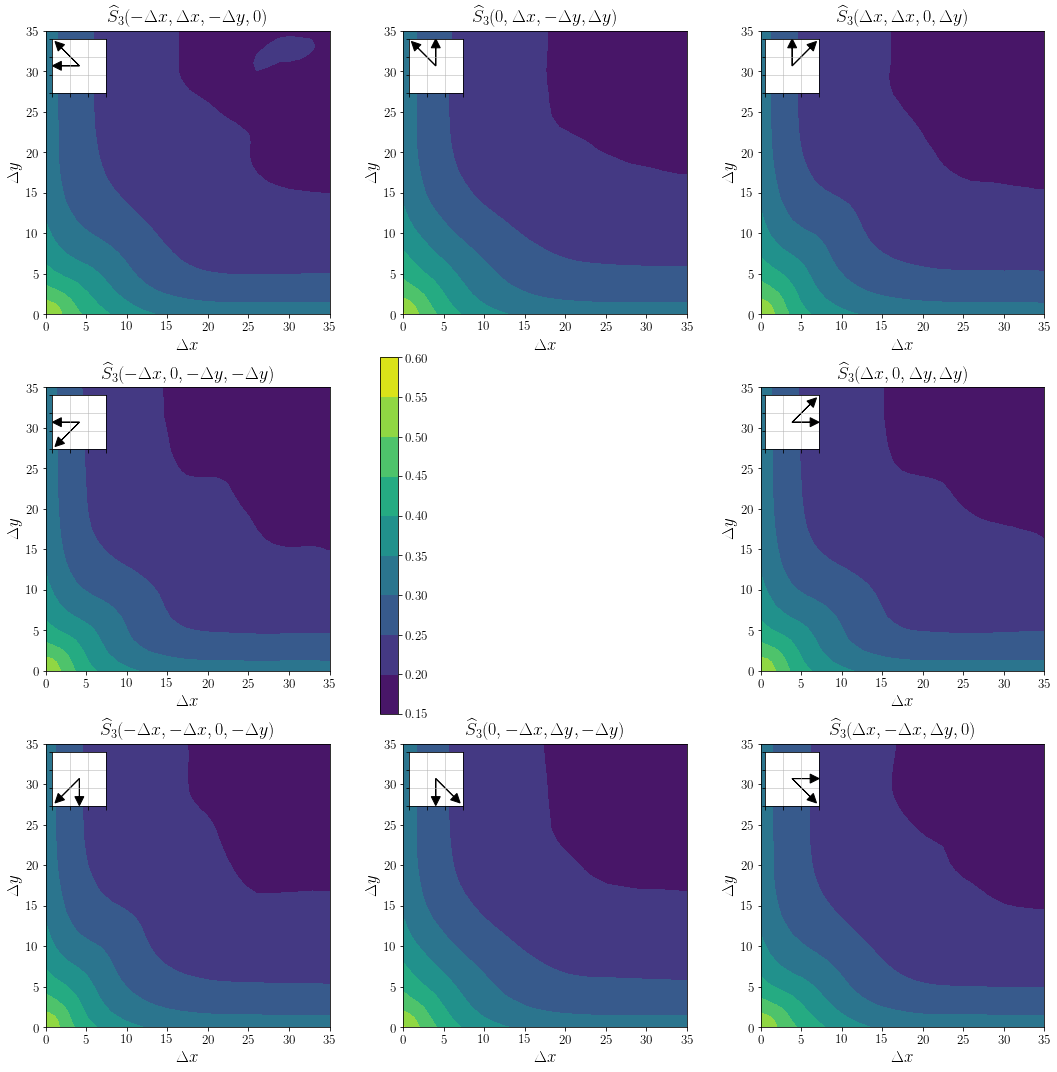

In [151]:
fig,ax=plt.subplots(3,3,figsize=(15,15))
pos=[(1,2), (0,2), (0,1), (0,0), (1,0), (2,0), (2,1), (2,2)]
ax[1,1].set_frame_on(False)
ax[1,1].set_xticks([]);ax[1,1].set_yticks([])
for i in range(len(S3)):
    d_scale_x=(dirs[i][0]**2+dirs[i][1]**2)**.5
    d_scale_y=(dirs[i][2]**2+dirs[i][3]**2)**.5
    cntr_plot=ax[pos[i][0],pos[i][1]].contourf(np.transpose(S3[i]),origin='lower',extent=(-dx/2.*d_scale_x,(dx_max-dx/2.)*d_scale_x,-dx/2.*d_scale_y,(dx_max-dx/2.)*d_scale_y),vmin=.15,vmax=.6)
    
ng=1
size_insert=.05
ax2_extents=((.72,.58,size_insert,size_insert),
             (.72,.91,size_insert,size_insert),
             (.39,.91,size_insert,size_insert),
             (.06,.91,size_insert,size_insert),
             (.06,.58,size_insert,size_insert),
             (.06,.25,size_insert,size_insert),
             (.39,.25,size_insert,size_insert),
             (.72,.25,size_insert,size_insert))

titles=(r'$\widehat{S}_3( \Delta x, 0       , \Delta y, \Delta y)$',
        r'$\widehat{S}_3( \Delta x, \Delta x,        0, \Delta y)$',
        r'$\widehat{S}_3(        0, \Delta x,-\Delta y, \Delta y)$',
        r'$\widehat{S}_3(-\Delta x, \Delta x,-\Delta y,        0)$',        
        r'$\widehat{S}_3(-\Delta x,        0,-\Delta y,-\Delta y)$',
        
        r'$\widehat{S}_3(-\Delta x,-\Delta x,        0,-\Delta y)$',
        r'$\widehat{S}_3(        0,-\Delta x, \Delta y,-\Delta y)$',
        r'$\widehat{S}_3( \Delta x,-\Delta x, \Delta y,        0)$')

for i in range(len(S3)):
    ax_i=ax[pos[i][0],pos[i][1]]
    ax_i.set_xlabel(r'$\Delta x$')
    ax_i.set_ylabel(r'$\Delta y$')
    ax_i.set_xlim(0,35)
    ax_i.set_ylim(0,35)
    ax_i.set_aspect('equal')
    ax_i.set_title(titles[i]) 
plt.tight_layout();
    
for i in range(len(S3)):
    ax2=fig.add_axes(ax2_extents[i])
    ax2.set_aspect('equal')
    ax2.set_xticks(range(-ng,ng+2),);ax2.set_yticks(range(-ng,ng+2))
    ax2.arrow(.5,.5,dirs[i][0],dirs[i][1], head_width=.5, head_length=.5, fc='k', ec='k')
    ax2.arrow(.5,.5,dirs[i][2],dirs[i][3], head_width=.5, head_length=.5, fc='k', ec='k')
    ax2.set_xlim(-ng,ng+1)
    ax2.set_ylim(-ng,ng+1)
    ax2.grid(linestyle='-',linewidth='0.5')
    for xlabel in ax2.get_xticklabels(): xlabel.set_visible(False)
    for ylabel in ax2.get_yticklabels(): ylabel.set_visible(False)     

ax_cbar=fig.add_axes([.27,.05,.11,.9],frame_on=False,xticks=[],yticks=[])
fig.add_axes()
cntr_bar=fig.colorbar(cntr_plot,ax=ax_cbar);

# Naive estimation of S3 in frequency domain:

An estimate of $S_3$ is obtained from the 4D inverse discrete Fourier transform (DFT), i.e. 

$$\widehat{S}_3(\Delta{x_1},\Delta{y_1},\Delta{x_2},\Delta{y_2}):=\mathrm{DF}^{-1}_4[hS3(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})]$$

of

$$ hS3(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2}):= hI(\omega_{x_1},\omega_{y_1})\;hI(\omega_{x_2},\omega_{y_2})\;hI^*(\omega_{x_1}+\omega_{x_2},\omega_{y_1}+\omega_{y_2})$$

in which

$$ 
hI(\omega_{x},\omega_{y}):= \mathrm{DF}_2[I(x,y)]\;\;\mathrm{with}\;\;
(\omega_x,\omega_y)\in[-N_x/2+1,N_x/2]\times[0,N_y/2]$$

is the discrete Fourier transform  of 

$$
I(x,y)\;\mathrm{for}\;
(x,y)\in[0,N_x-1]\times[0,N_y-1].
$$

In order to compute $ hS3(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})$ so that $S_3(\Delta x_1,\Delta y_1,\Delta x_2,\Delta y_2)$ is known for $(\Delta x_1,\Delta y_1,\Delta x_2,\Delta y_2)\in[0,N_x-1]\times[0,N_y-1]\times[0,N_x-1]\times[0,N_y-1]$, we need to know

$$
hI(\omega_{x_1}+\omega_{x_2},\omega_{y_1}+\omega_{y_2})\;\;\mathrm{for}\;(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})\in[-N_x/2+1,N_x/2]\times[-N_y/2+1,N_y/2]\times[-N_x/2+1,N_x/2]\times[0,N_y/2]
$$

or, equivalently,

$$
hI(\omega_{x},\omega_{y})\;\;\mathrm{for}\;(\omega_{x},\omega_{y})\in[-N_x+2,N_x]\times[-N_y/2+1,N_y]
$$

which, for some frequency pairs $(\omega_{x},\omega_{y})$, is not explicitely evaluated when computing the FFT $hI$.
To obtain those values, we can make use of the following symmetries,

\begin{align*}
1)&\; I\in\mathbb{R}\implies hI(\omega_{x},\omega_{y})=hI^*(-\omega_{x},-\omega_{y}).\\
2)&\; \mathrm{by\ definition\ of\ DF},\; hI(\omega_{x},\omega_{y})=hI(\omega_{x}+kN_x,\omega_{y})=hI(\omega_{x},\omega_{y}+\ell N_y)=hI(\omega_{x}+kN_x,\omega_{y}+\ell N_y)\;\;\forall\;k,\ell\in\mathbb{N}.
\end{align*}

Then, we can proceed as follows. For some fixed $(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})\in[-N_x/2+1,N_x/2]\times[-N_y/2+1,N_y/2]\times[-N_x/2+1,N_x/2]\times[0,N_y/2]$, let

\begin{align*}
a:=&\;\Re\{hI(\omega_{x_1},\omega_{y_1})\}\\
b:=&\;\Im\{hI(\omega_{x_1},\omega_{y_1})\}\\
c:=&\;\Re\{hI(\omega_{x_2},\omega_{y_2})\}\\
d:=&\;\Im\{hI(\omega_{x_2},\omega_{y_2})\}\\
e:=&\;\Re\{hI(\omega_{x_1}+\omega_{x_2},\omega_{y_1}+\omega_{y_2})\}\\
f:=&\;\Im\{hI(\omega_{x_1}+\omega_{x_2},\omega_{y_1}+\omega_{y_2})\}
\end{align*}

so that

\begin{align*}
\Re\{hS3(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})\}=&\;a\cdot c\cdot e+a\cdot d\cdot f+b\cdot c\cdot f-b\cdot d\cdot e,\\
\Im\{hS3(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})\}=&\;-a\cdot c\cdot f+a\cdot d\cdot e+b\cdot c\cdot e+b\cdot d\cdot f.
\end{align*}

However, as mentioned before, for some $(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})$, the values of $a,\dots,f$ need to be evaluated using symmetries of $hI$.

Note that the values $hI(\omega_{x},\omega_y)$ and $hS3(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})$ are stored in row-major 1D arrays which we also denote by $hI$ and $hS3$.
Thus, the mappings

\begin{align*}
f:&\;[-N_{\bullet}/2+1,N_\bullet/2]\rightarrow[0,N_\bullet-1]\\
:&\;\omega\mapsto \omega\;\;\;\;\;\;\;\;\;\;\,\mathrm{if}\; \omega\geq 0\\
&\;\hspace{1.05cm}\omega+N_{\bullet}\;\mathrm{if}\; \omega< 0
\end{align*}
and
\begin{align*}
g_2\circ f&\;:[-N_x/2+1,N_x/2]\times[0,N_y/2]\rightarrow [0,N_x(N_y/2+1)-1]\\
&\;:(\omega_{x_1},\omega_{y_1})\mapsto f(\omega_{y_1})+(N_y/2+1)f(\omega_{x_1})\\
g_4\circ f&\;:[-N_x/2+1,N_x/2]\times[-N_y/2+1,N_y/2]\times[-N_x/2+1,N_x/2]\times[0,N_y/2]\rightarrow [0,N_x^2N_y(N_y/2+1)-1]\\
&\;:(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})\mapsto f(\omega_{y_2})+(N_y/2+1)(f(\omega_{x_2})+N_x(f(\omega_{y_1})+N_yf(\omega_{x_1})))\\
\end{align*}

are such that

\begin{align*}
hI[g_2\circ f(\omega_{x_1},\omega_{y_1})]=&\;hI(\omega_{x_1},\omega_{y_1})\\
hS3[g_4\circ f(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})]=&\;hS3(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})\\
\end{align*}

The following is implemented (see C++ code),

1) Get $(a,b)$ for all $(\omega_{x_1},\omega_{y_1})\in[-N_x/2+1,N_x/2]\times[-N_y/2+1,N_y/2]$:

- $(\omega_{x_1},\omega_{y_1})\in[-N_x/2+1,N_x/2]\times[0,N_y/2]$:

\begin{align*}
a=&\;\Re\{hI(\omega_{x_1},\omega_{y_1})\}=\Re\{hI[g_2\circ f(\omega_{x_1},\omega_{y_1})]\}\\
b=&\;\Im\{hI(\omega_{x_1},\omega_{y_1})\}=\Im\{hI[g_2\circ f(\omega_{x_1},\omega_{y_1})]\}
\end{align*}

- $(\omega_{x_1},\omega_{y_1})\in[-N_x/2+1,N_x/2)\times[-N_y/2+1,0)$:

$$hI(\omega_{x_1},\omega_{y_1})=hI^*(-\omega_{x_1},-\omega_{y_1})
$$

and $(-\omega_{x_1},-\omega_{y_1})\in(-N_x/2,N_x/2-1]\times(0,N_y/2-1] \subset [-N_x/2+1,N_x/2]\times[0,N_y/2]$ so that

\begin{align*}
a=&\;\Re\{hI^*(-\omega_{x_1},-\omega_{y_1})\}
=\Re\{hI[g_2\circ f(-\omega_{x_1},-\omega_{y_1})]\}\\
b=&\;\Im\{hI^*(-\omega_{x_1},-\omega_{y_1})\}
=-\Im\{hI[g_2\circ f(-\omega_{x_1},-\omega_{y_1})]\}.
\end{align*}


- $(\omega_{x_1},\omega_{y_1})\in\{N_x/2\}\times[-N_y/2+1,0)$:

$$hI(\omega_{x_1},\omega_{y_1})=hI^*(-\omega_{x_1},-\omega_{y_1})=hI^*(N_x-\omega_{x_1},-\omega_{y_1})
$$

and $(N_x-\omega_{x_1},-\omega_{y_1})\in\{N_x/2\}\times(0,N_y/2-1] \subset [-N_x/2+1,N_x/2]\times[0,N_y/2]$ so that

\begin{align*}
a=&\;\Re\{hI^*(N_x-\omega_{x_1},-\omega_{y_1})\}
=\Re\{hI[g_2\circ f(N_x-\omega_{x_1},-\omega_{y_1})]\}\\
b=&\;\Im\{hI^*(N_x-\omega_{x_1},-\omega_{y_1})\}
=-\Im\{hI[g_2\circ f(N_x-\omega_{x_1},-\omega_{y_1})]\}.
\end{align*}

2) Get $(c,d)$ for all $(\omega_{x_2},\omega_{y_2})\in[-N_x/2+1,N_x/2]\times[0,N_y/2]$:

\begin{align*}
c=&\;\Re\{hI(\omega_{x_2},\omega_{y_2})\}=\Re\{hI[g_2\circ f(\omega_{x_2},\omega_{y_2})]\}\\
d=&\;\Im\{hI(\omega_{x_2},\omega_{y_2})\}=\Im\{hI[g_2\circ f(\omega_{x_2},\omega_{y_2})]\}
\end{align*}

3) Get $(e,f)$ for all $(\omega_{x_1},\omega_{y_1},\omega_{x_2},\omega_{y_2})\in[-N_x/2+1,N_x/2]\times[-N_y/2+1,N_y/2]\times[-N_x/2+1,N_x/2]\times[0,N_y/2]$:

First, let

\begin{align*}
\omega_{x}:=\left\{
\begin{matrix}
\omega_{x_1}+\omega_{x_2}+N_x & \mathrm{if}\;  \omega_{x_1}+\omega_{x_2}<-N_x/2+1,\hfill\\
\omega_{x_1}+\omega_{x_2}-N_x & \mathrm{if}\;  \omega_{x_1}+\omega_{x_2}>N_x/2,\hfill\\
\omega_{x_1}+\omega_{x_2}& \mathrm{otherwise}.\hfill
\end{matrix}
\right.
\end{align*}

and

\begin{align*}
\omega_{y}:=\left\{
\begin{matrix}
\omega_{y_1}+\omega_{y_2}-N_y & \mathrm{if}\;  \omega_{y_1}+\omega_{y_2}>N_y/2,\hfill\\
\omega_{y_1}+\omega_{y_2}& \mathrm{otherwise}.\hfill
\end{matrix}
\right.
\end{align*}

so that $(\omega_{x},\omega_{y})\in[-N_x/2+1,N_x/2]\times[-N_y/2+1,N_y/2]$.
Then, we proceed as follows:

- $(\omega_{x},\omega_{y})\in[-N_x/2+1,N_x/2]\times[0,N_y/2]$:

\begin{align*}
a=&\;\Re\{hI(\omega_{x},\omega_{y})\}=\Re\{hI[g_2\circ f(\omega_{x},\omega_{y})]\}\\
b=&\;\Im\{hI(\omega_{x},\omega_{y})\}=\Im\{hI[g_2\circ f(\omega_{x},\omega_{y})]\}
\end{align*}

- $(\omega_{x},\omega_{y})\in[-N_x/2+1,N_x/2)\times[-N_y/2+1,0)$:

$$hI(\omega_{x},\omega_{y})=hI^*(-\omega_{x},-\omega_{y})
$$

and $(-\omega_{x},-\omega_{y})\in(-N_x/2,N_x/2-1]\times(0,N_y/2-1] \subset [-N_x/2+1,N_x/2]\times[0,N_y/2]$ so that

\begin{align*}
a=&\;\Re\{hI^*(-\omega_{x},-\omega_{y})\}
=\Re\{hI[g_2\circ f(-\omega_{x},-\omega_{y})]\}\\
b=&\;\Im\{hI^*(-\omega_{x},-\omega_{y})\}
=-\Im\{hI[g_2\circ f(-\omega_{x},-\omega_{y})]\}.
\end{align*}


- $(\omega_{x},\omega_{y})\in\{N_x/2\}\times[-N_y/2+1,0)$:

$$hI(\omega_{x},\omega_{y})=hI^*(-\omega_{x},-\omega_{y})=hI^*(N_x-\omega_{x},-\omega_{y})
$$

and $(N_x-\omega_{x},-\omega_{y})\in\{N_x/2\}\times(0,N_y/2-1] \subset [-N_x/2+1,N_x/2]\times[0,N_y/2]$ so that

\begin{align*}
a=&\;\Re\{hI^*(N_x-\omega_{x},-\omega_{y})\}
=\Re\{hI[g_2\circ f(N_x-\omega_{x},-\omega_{y})]\}\\
b=&\;\Im\{hI^*(N_x-\omega_{x},-\omega_{y})\}
=-\Im\{hI[g_2\circ f(N_x-\omega_{x},-\omega_{y})]\}.
\end{align*}




The amount of memory required to store $hS3$ for a single 2D section of size $N_x\times N_y$ is $N_x^2N_y(N_y/2+1)=O((N_xN_y)^2)$.
For $N_x\times N_y= 560\times 920$, this amounts to more memory than what can reasonably be allocated on a personal computer.

In [31]:
# Write data of 0-th slice in a csv file
os.chdir('/home/nicolas/Dropbox/Git/npcf/')

fp=open('im00.csv','w')
for i in range(len(im[0])):
    for j in range(len(im[0][i])):
        fp.write(str(im[0][i][j]))
        if j<len(im[0][i])-1:
            fp.write(',')
        else:
            fp.write('\n')
fp.close()

Okay, let's test the implementation for 56x56 sub-slice starting from (x0,y0)=(0,0):

In [53]:
# Divide the slice into smaller sub-slices
nx_npcf=56;nnx_npcf=int(nx/nx_npcf)
ny_npcf=56;nny_npcf=int(ny/ny_npcf)
x0=0;y0=0

os.chdir('/home/nicolas/Dropbox/Git/npcf/')

S3_FFT=np.zeros(nx_npcf*ny_npcf)

t_S3_FFT=time.time()
verb=2
out=os.popen('./dist/Release/GNU-Linux/npcf '+str(nx_npcf)+' '+str(ny_npcf)+' '
             +str(x0)+' '+str(y0)+' '+str(verb)+' im00.csv')
print(out.read())
t_S3_FFT=time.time()-t_S3_FFT
print('Time: {0:.2f} sec.\n'.format(t_S3_FFT)) 




2D slice of data: 

0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0
0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0

In [38]:
# Divide the all slice into smaller slices
nx_npcf=56;nnx_npcf=int(nx/nx_npcf)
ny_npcf=56;nny_npcf=int(ny/ny_npcf)

os.chdir('/home/nicolas/Dropbox/Git/npcf/')

S3_FFT=np.zeros(nx_npcf*ny_npcf)

verb=1

t_S3_FFT=time.time()
for ix in range(nnx_npcf):
    for jx in range(nny_npcf):
        out=os.popen('./dist/Release/GNU-Linux/npcf '+str(nx_npcf)+' '+str(ny_npcf)+' '
                     +str(ix*nx_npcf)+' '+str(jx*ny_npcf)+' '+str(verb)+' im00.csv')        
        print('Section #{0:d}/{1:d}: [x0,y0]x[x0+nx,y0+ny]=[{2:d},{3:d}]x[{4:d},{5:d}]'.format\
              (ix*nny_npcf+jx+1,nnx_npcf*nny_npcf,
               ix*nx_npcf,ix*nx_npcf+nx_npcf,
               jx*ny_npcf,jx*ny_npcf+ny_npcf)) 
        print(out.read())

t_S3_FFT=time.time()-t_S3_FFT        

Section #1/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[0,56]


Section #2/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[56,112]


Section #3/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[112,168]


Section #4/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[168,224]


Section #5/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[224,280]


Section #6/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[280,336]


Section #7/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[336,392]


Section #8/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[392,448]


Section #9/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[448,504]


Section #10/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[504,560]


Section #11/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[560,616]


Section #12/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[616,672]


Section #13/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[672,728]


Section #14/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[728,784]


Section #15/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[784,840]


Section #16/160: [x0,y0]x[x0+nx,y0+ny]=[0,56]x[840,896]


Section #17/160: [x0,y0]x[x0+nx,y0+ny]=[56,112]x[0,56]


Section #18/160: [x0,y0]x[x0



Section #137/160: [x0,y0]x[x0+nx,y0+ny]=[448,504]x[448,504]


Section #138/160: [x0,y0]x[x0+nx,y0+ny]=[448,504]x[504,560]


Section #139/160: [x0,y0]x[x0+nx,y0+ny]=[448,504]x[560,616]


Section #140/160: [x0,y0]x[x0+nx,y0+ny]=[448,504]x[616,672]


Section #141/160: [x0,y0]x[x0+nx,y0+ny]=[448,504]x[672,728]


Section #142/160: [x0,y0]x[x0+nx,y0+ny]=[448,504]x[728,784]


Section #143/160: [x0,y0]x[x0+nx,y0+ny]=[448,504]x[784,840]


Section #144/160: [x0,y0]x[x0+nx,y0+ny]=[448,504]x[840,896]


Section #145/160: [x0,y0]x[x0+nx,y0+ny]=[504,560]x[0,56]


Section #146/160: [x0,y0]x[x0+nx,y0+ny]=[504,560]x[56,112]


Section #147/160: [x0,y0]x[x0+nx,y0+ny]=[504,560]x[112,168]


Section #148/160: [x0,y0]x[x0+nx,y0+ny]=[504,560]x[168,224]


Section #149/160: [x0,y0]x[x0+nx,y0+ny]=[504,560]x[224,280]


Section #150/160: [x0,y0]x[x0+nx,y0+ny]=[504,560]x[280,336]


Section #151/160: [x0,y0]x[x0+nx,y0+ny]=[504,560]x[336,392]


Section #152/160: [x0,y0]x[x0+nx,y0+ny]=[504,560]x[392,448]


Section #1

In [45]:
print('Total time: {0:.2f} sec.'.format(t_S3_FFT)) 
print('Number of sub-slices: {0:d}.'.format(nnx_npcf*nny_npcf)) 
print('Time: {0:.2f} sec per sub-slice.\n'.format(t_S3_FFT/(nnx_npcf*nny_npcf))) 

Total time: 289.93 sec.
Number of sub-slices: 160.
Time: 1.81 sec per sub-slice.



# Filtering

# Translation-based simulation of non-Gaussian fields